In [79]:
import sys

sys.path.append('../')

In [87]:
import numpy as np
import graphviz
from IPython.display import display
from environments.tree.tree import NaryTreeEnvironment
from environments.tree.data import TrajectoryDataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import hypll
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll.optim import RiemannianAdam
import hypll.nn as hnn
from hypll.tensors import TangentTensor

import argparse
from environments.tree.data import TrajectoryDataset
from networks.hypnets import HyperbolicMLP, manifold_map
from networks.nets import SmallEncoder
from utils import get_maze, load_model, load_tree_model
import os
import json


In [168]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# directory w/ pretrained weights
# saved = '/home/yongweic/hyperbolic/saved_models/tree_experiment2_hyperbolic_False_curvature_1.0_learnable_True_epochs_128_trajectories_1000_depth_4_branch_2_embeddingdim_2_gamma_0.1_batch_128'
saved = '/home/yongweic/hyperbolic/saved_models/tree_experiment2_hyperbolic_True_curvature_1.0_learnable_False_epochs_128_trajectories_10000_depth_6_branch_2_embeddingdim_2_gamma_0.1_batch_128'
config = json.load(open(os.path.join(saved, 'config.json')))
print(config)

branching_factor = config['branching_factor']
depth = config['depth']

env = NaryTreeEnvironment(depth=depth, branching_factor=branching_factor)
hyperbolic = config['hyperbolic']
model_dict = load_tree_model(config, device, pretrained_path=saved, epoch=128)

encoder1 = model_dict['encoder1']
encoder2 = model_dict['encoder2']
manifold = model_dict['manifold']


{'project': 'tree', 'custom': '2', 'hyperbolic': True, 'embedding_dim': 2, 'curvature': 1.0, 'learnable_curvature': False, 'num_epochs': 128, 'num_trajectories': 10000, 'batch_size': 128, 'num_negatives': 64, 'max_steps': 100, 'num_workers': 24, 'learning_rate': 0.01, 'depth': 6, 'branching_factor': 2, 'gamma': 0.1, 'order_name': '', 'eval_trials': 10, 'temperature': 0.1, 'architecture': 'MLP'}
loading pretrained...


Node path from 12 to 6: [12, 5, 2, 6]
[0, 0, 2]
Action path from 12 to 6: [(12, 0), (5, 0), (2, 2), (6, 3)]


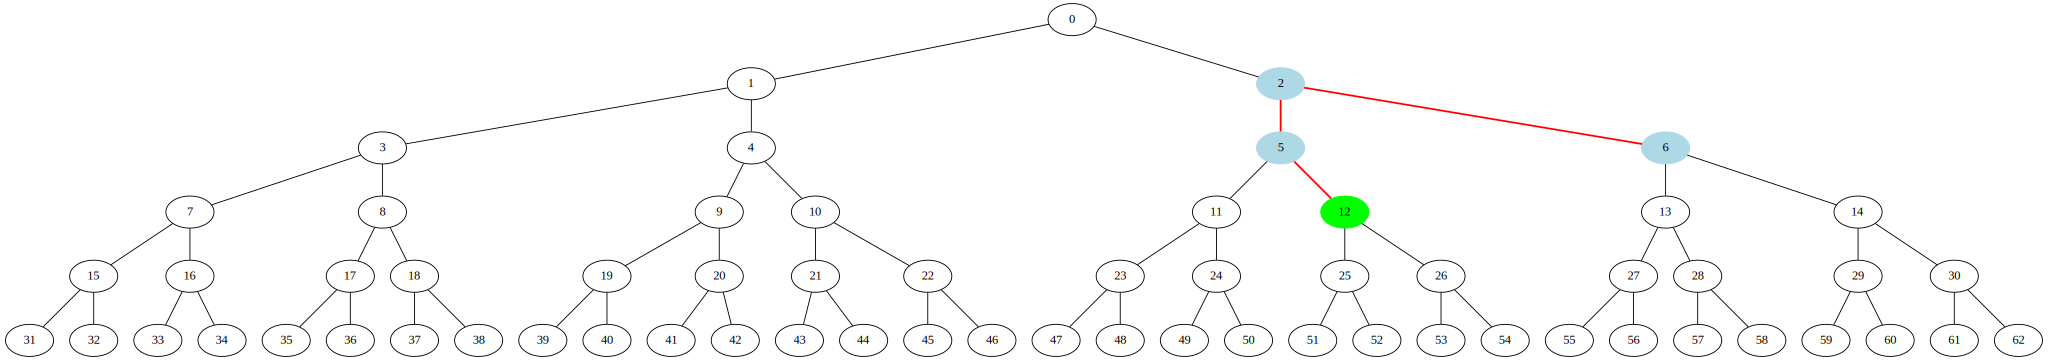

After action 0:


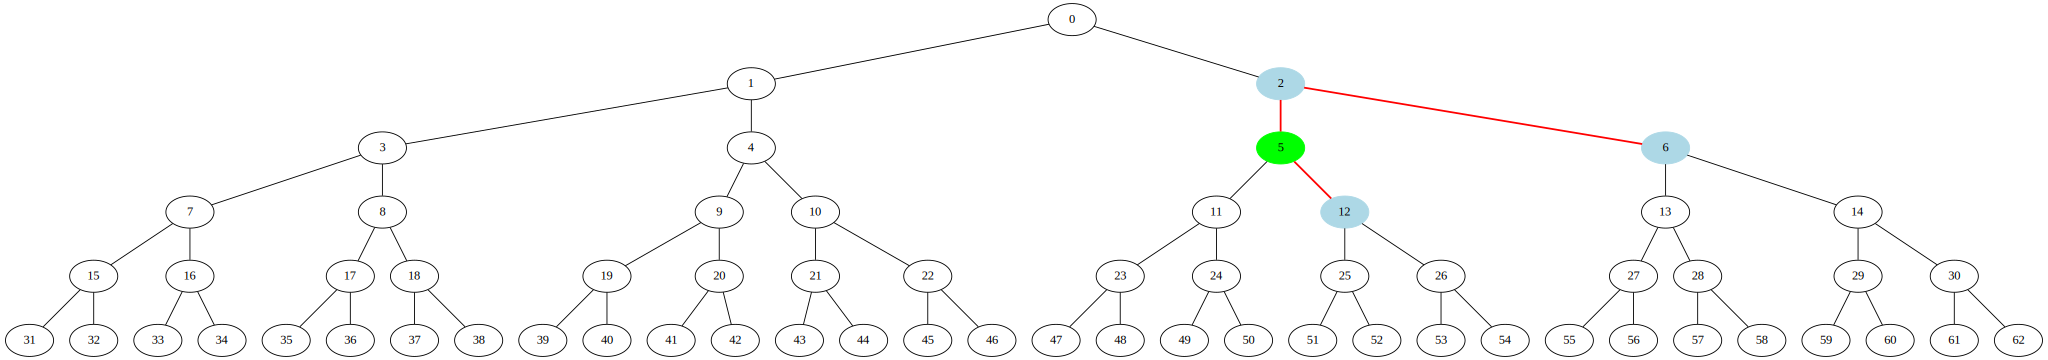

After action 0:


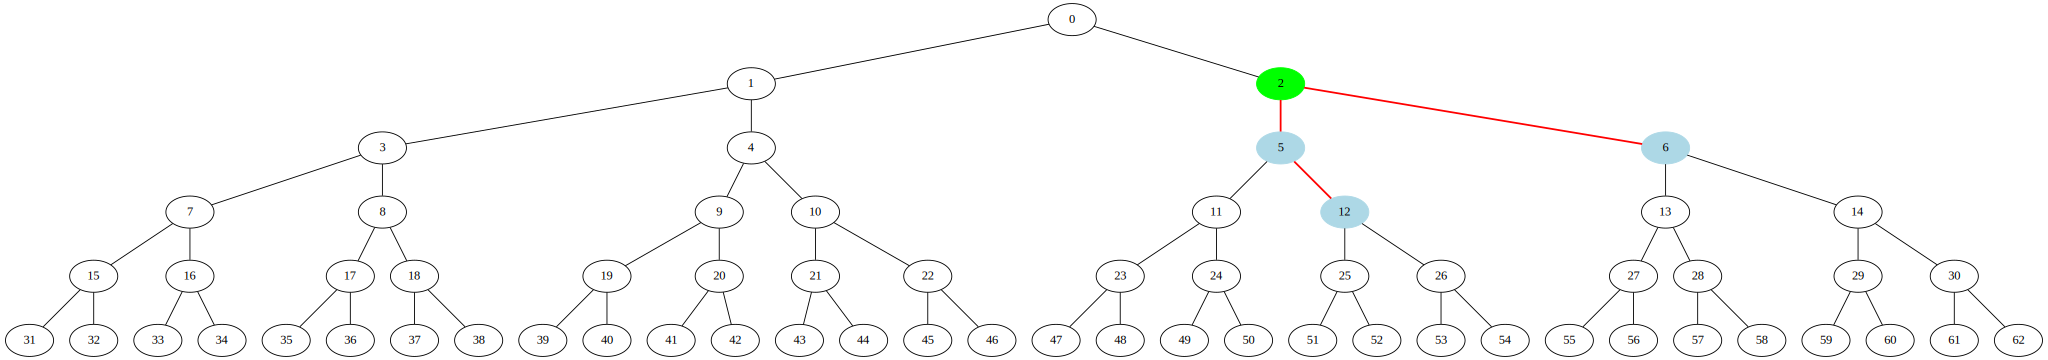

After action 2:


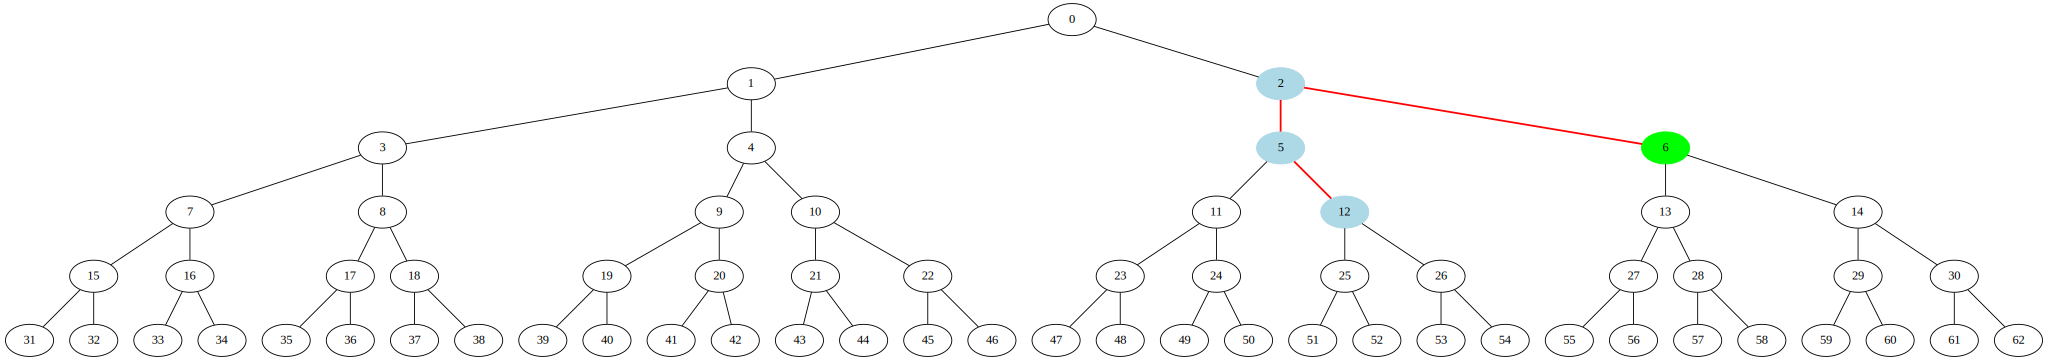

In [169]:
env = NaryTreeEnvironment(depth=depth, branching_factor=branching_factor)

# Choose two nodes
start_node = 12
end_node = 6

# Get the node path
node_path = env.get_node_path(start_node, end_node)
print(f"Node path from {start_node} to {end_node}: {node_path}")

# Get the action path
action_path = env.get_action_path(start_node, end_node)
actions = [x[1] for x in action_path][:-1]
print(actions)

print(f"Action path from {start_node} to {end_node}: {action_path}")

# Display the tree with highlighted path
env.agent_position = start_node
env.display(highlight_path=node_path)

for action in actions:
    env.move_agent(action)
    print(f"After action {action}:")
    env.display(highlight_path=node_path)


In [170]:
ds = TrajectoryDataset(depth, branching_factor, 100)

gamma: 0.1


0 2
1 4
3 8
7 16
15 32
31 63


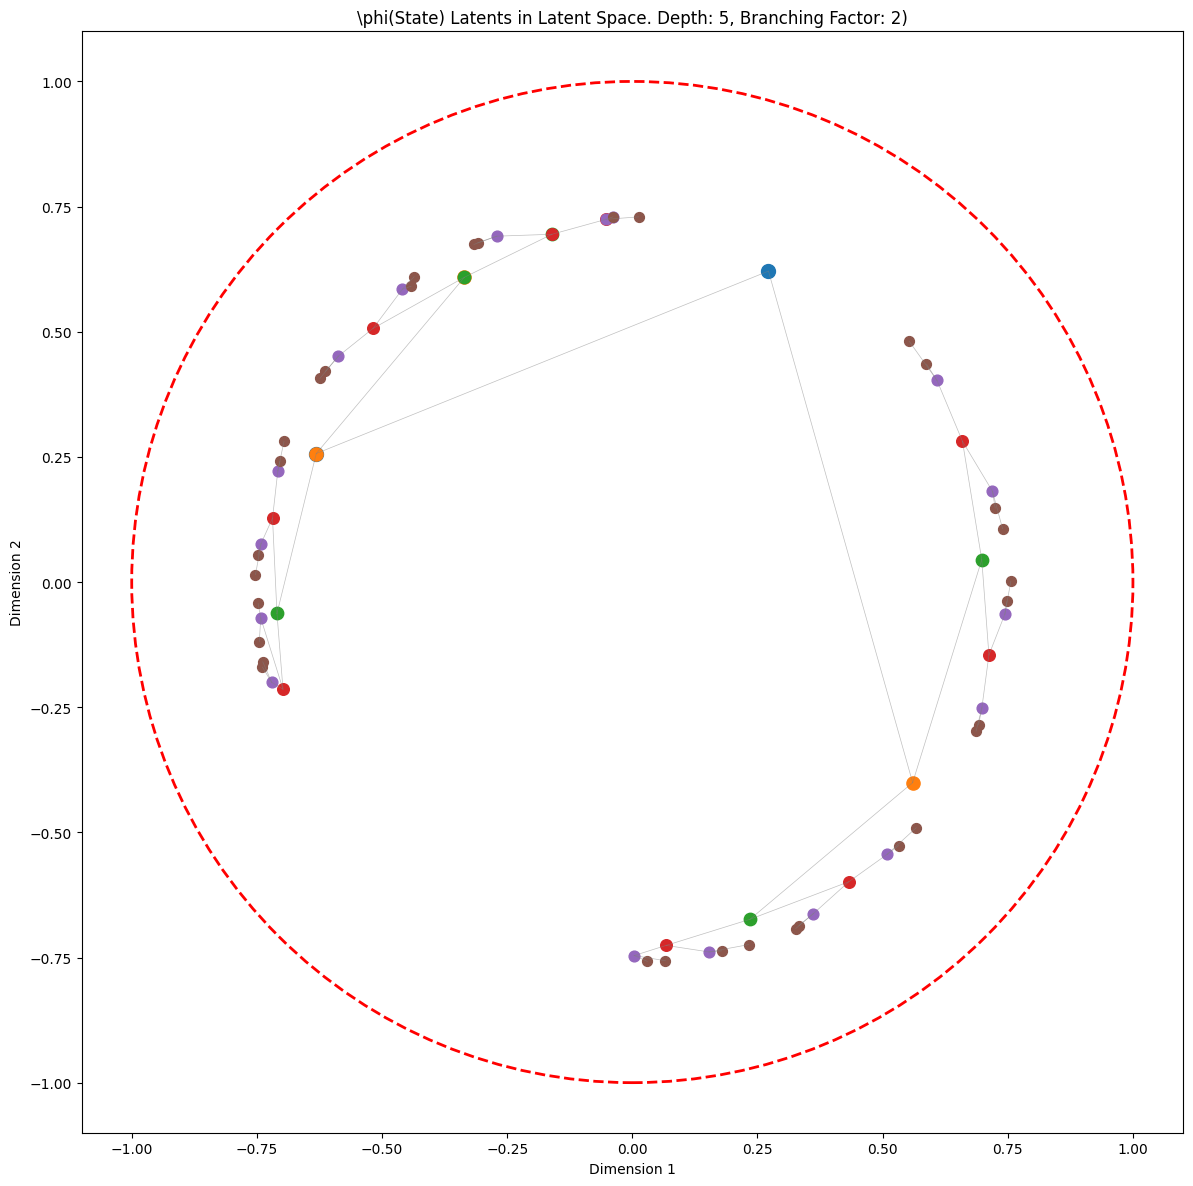

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import torch

with torch.no_grad():
    nodes = torch.arange(env.num_nodes)[:, None]
    latents = encoder2(nodes)
    if hyperbolic:
        latents = latents.tensor
        
    

max_depth = int(np.log(env.num_nodes) / np.log(branching_factor))
sizes = np.linspace(100, 50, max_depth + 1)  # Decreasing sizes from 100 to 50

plt.figure(figsize=(12, 12))  # Make it square

if hyperbolic:
    # Plot the unit circle
    circle = plt.Circle((0, 0), 1, fill=False, color='r', linestyle='--', linewidth=2)
    plt.gca().add_artist(circle)

# Plot lines connecting parents to children
for node in range(1, env.num_nodes):  # Start from 1 to skip the root
    parent = (node - 1) // branching_factor
    plt.plot([latents[parent, 0], latents[node, 0]], 
             [latents[parent, 1], latents[node, 1]], 
             color='gray', alpha=0.5, linewidth=0.5)

# Plot nodes
for i in range(max_depth + 1):
    l = branching_factor**i - 1
    r = min(branching_factor**(i + 1), env.num_nodes)
    print(l, r)
    plt.scatter(latents[l:r, 0], latents[l:r, 1], s=sizes[i])

plt.title(f"\phi(State) Latents in Latent Space. Depth: {max_depth}, Branching Factor: {branching_factor})")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.axis('equal')  # This ensures the circle is circular and not elliptical
if hyperbolic:
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')  # This ensures the aspect ratio stays constant
plt.tight_layout()
plt.show()

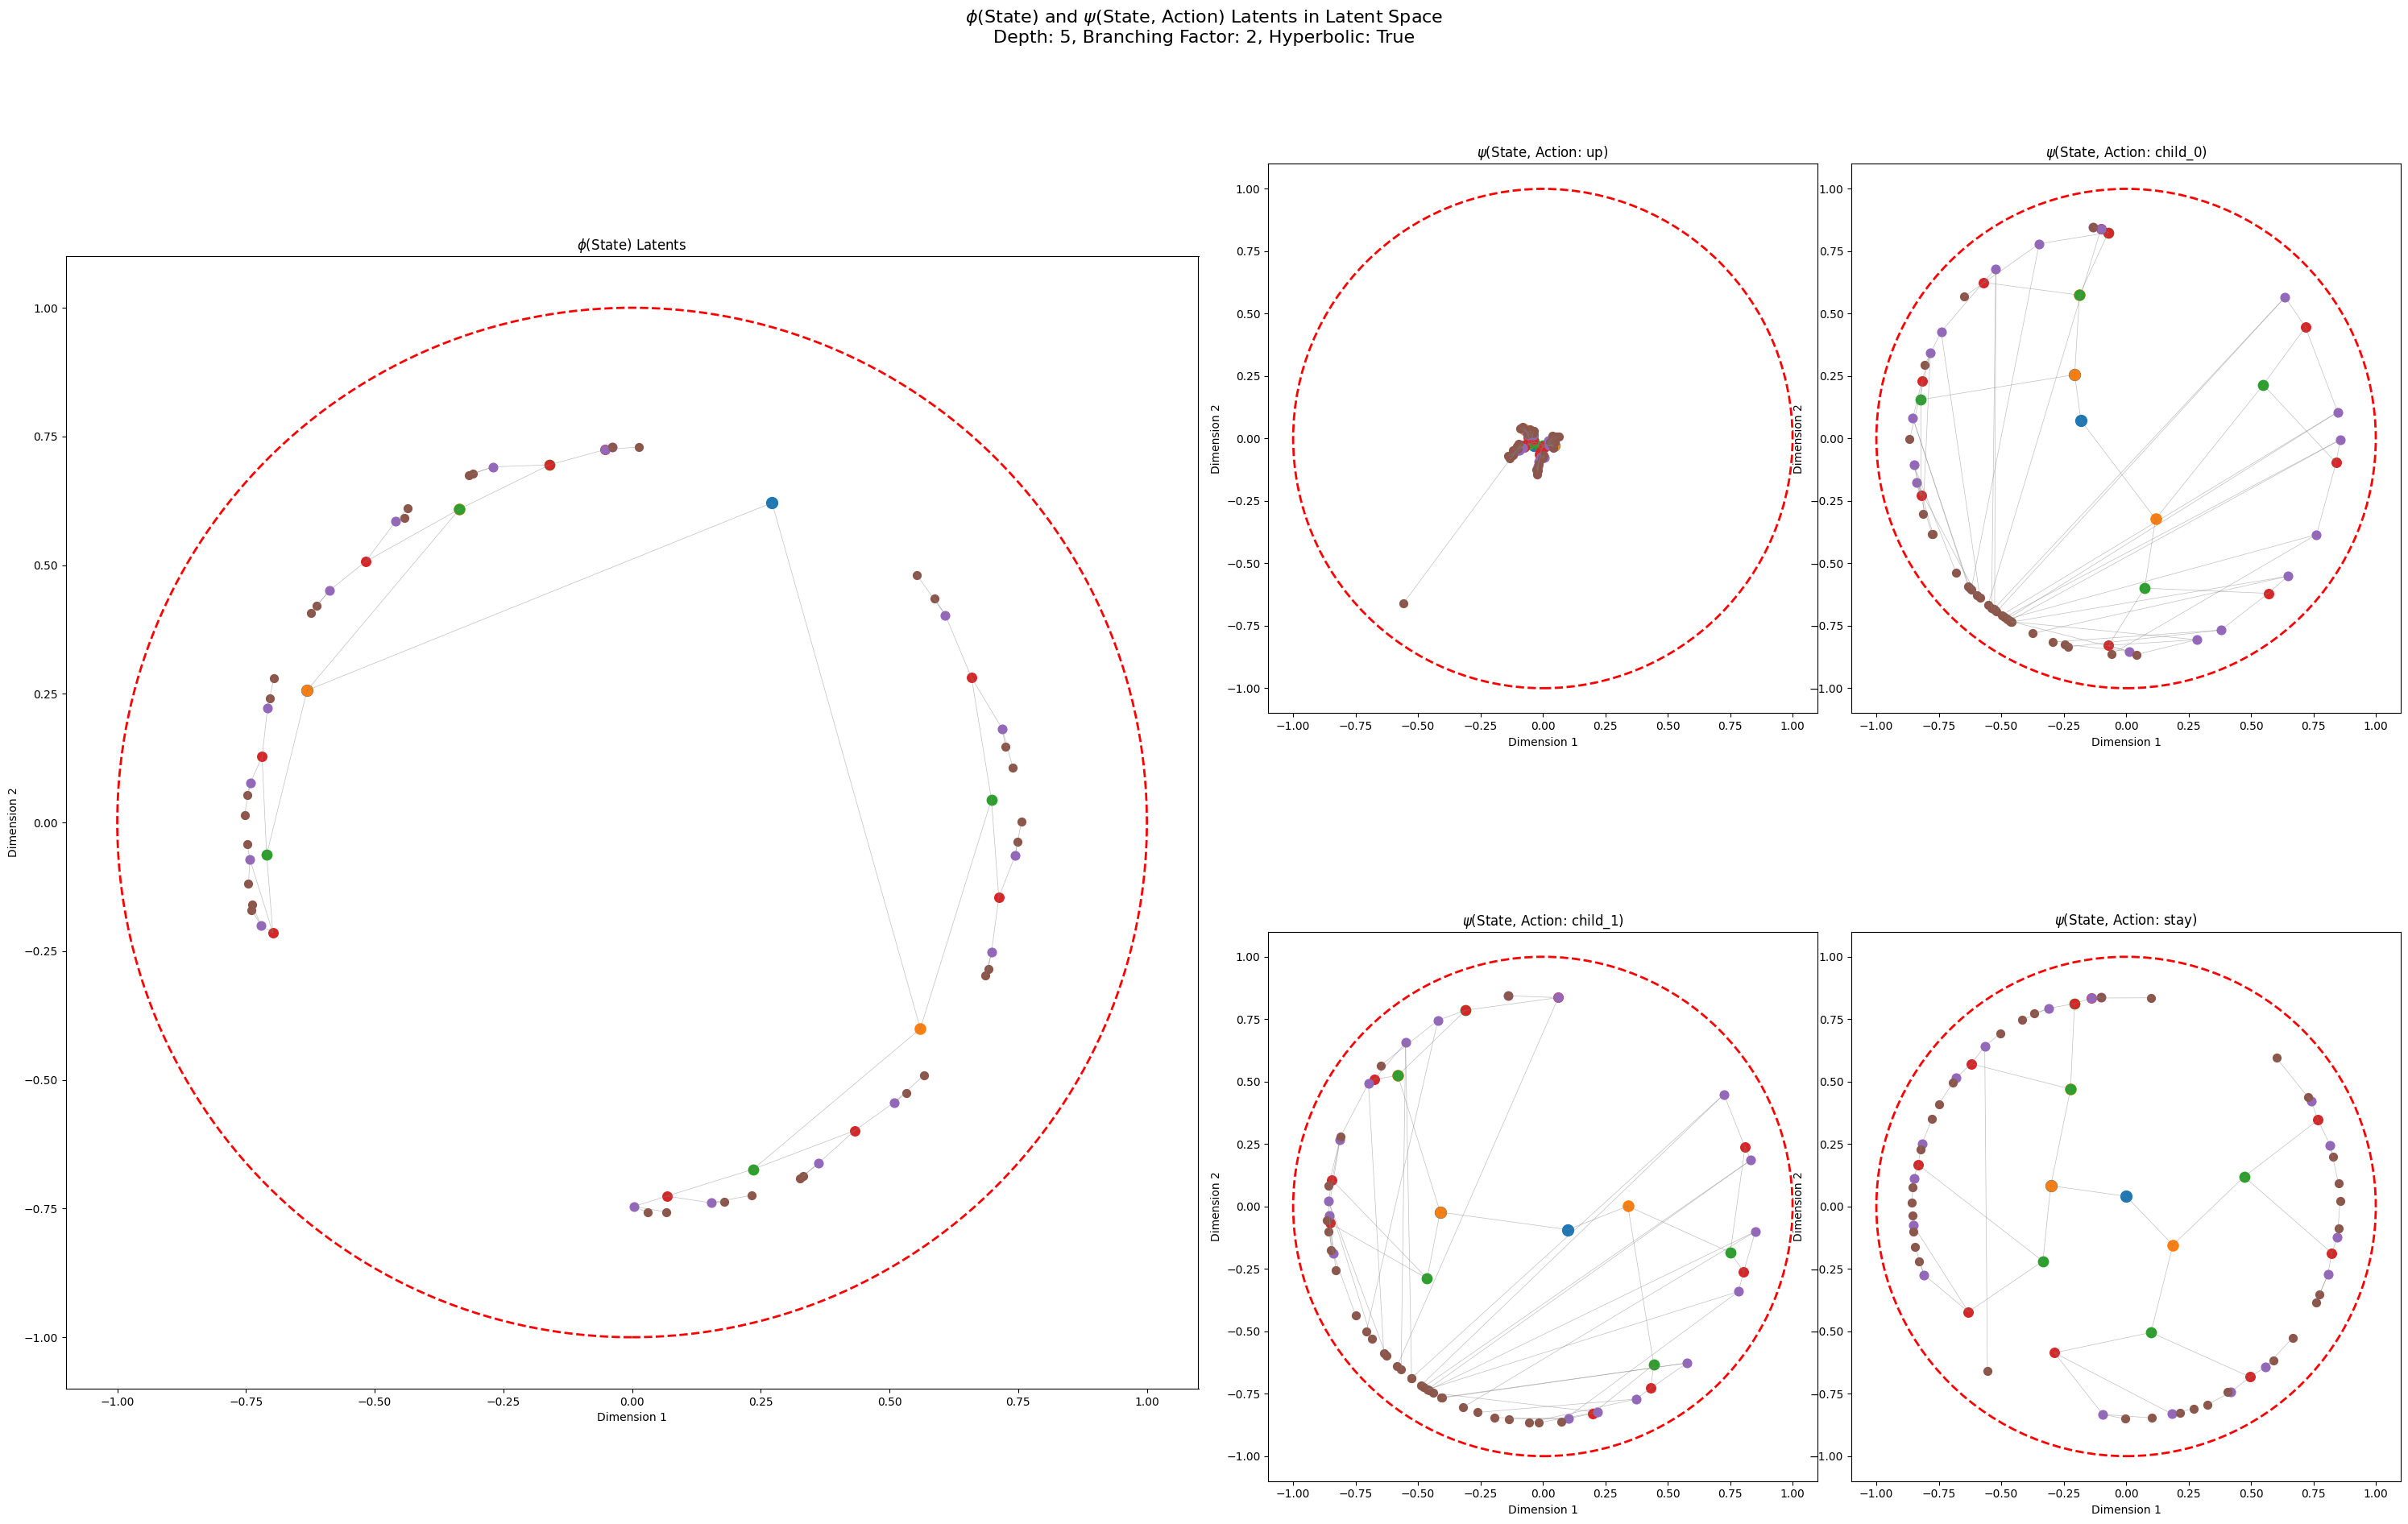

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Function to create the state latents plot
def plot_state_latents(ax):
    with torch.no_grad():
        nodes = torch.arange(env.num_nodes)[:, None]
        latents = encoder2(nodes)
        if hyperbolic:
            latents = latents.tensor
    
    if hyperbolic:
        circle = plt.Circle((0, 0), 1, fill=False, color='r', linestyle='--', linewidth=2)
        ax.add_artist(circle)
    
    for node in range(1, env.num_nodes):
        parent = (node - 1) // branching_factor
        ax.plot([latents[parent, 0], latents[node, 0]], 
                [latents[parent, 1], latents[node, 1]], 
                color='gray', alpha=0.5, linewidth=0.5)
    
    for i in range(max_depth + 1):
        l = branching_factor**i - 1
        r = min(branching_factor**(i + 1), env.num_nodes)
        ax.scatter(latents[l:r, 0], latents[l:r, 1], s=sizes[i])
    
    ax.set_title(r"$\phi$(State) Latents")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.axis('equal')
    if hyperbolic:
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal', adjustable='box')

# Main plotting code
num_actions = branching_factor + 2
max_depth = int(np.log(env.num_nodes) / np.log(branching_factor))
sizes = np.linspace(100, 50, max_depth + 1)
grid_size = int(np.ceil(np.sqrt(num_actions)))

fig = plt.figure(figsize=(30, 20))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])

# Left side: state latents
ax_state = fig.add_subplot(gs[0, 0])
plot_state_latents(ax_state)

# Right side: action latents grid
gs_right = gs[0, 1].subgridspec(grid_size, grid_size)

for a in range(num_actions):
    row = a // grid_size
    col = a % grid_size
    ax = fig.add_subplot(gs_right[row, col])
    
    action_name = env.action_map[a]
    
    with torch.no_grad():
        nodes = torch.arange(env.num_nodes)[:, None]
        actions = torch.cat([nodes, torch.full(nodes.shape, a)], dim=-1)
        latents = encoder1(actions)
        if hyperbolic:
            latents = latents.tensor
    
    if hyperbolic:
        circle = plt.Circle((0, 0), 1, fill=False, color='r', linestyle='--', linewidth=2)
        ax.add_artist(circle)
    
    for node in range(1, env.num_nodes):
        parent = (node - 1) // branching_factor
        ax.plot([latents[parent, 0], latents[node, 0]], 
                [latents[parent, 1], latents[node, 1]], 
                color='gray', alpha=0.5, linewidth=0.5)
    
    for i in range(max_depth + 1):
        l = branching_factor**i - 1
        r = min(branching_factor**(i + 1), env.num_nodes)
        ax.scatter(latents[l:r, 0], latents[l:r, 1], s=sizes[i])
    
    ax.set_title(f"$\psi$(State, Action: {action_name})")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.axis('equal')
    if hyperbolic:
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal', adjustable='box')

# Remove any unused subplots
for a in range(num_actions, grid_size * grid_size):
    row = a // grid_size
    col = a % grid_size
    fig.delaxes(gs_right[row, col].subgridspec(1, 1)[0, 0])

fig.suptitle(r"$\phi$(State) and $\psi$(State, Action) Latents in Latent Space" + 
             f"\nDepth: {max_depth}, Branching Factor: {branching_factor}, Hyperbolic: {hyperbolic}", 
             fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Function to create the state latents plot (unchanged)
def plot_state_latents(ax):
    # ... (keep the existing function as is)

# Main plotting code
num_actions = branching_factor + 2
max_depth = int(np.log(env.num_nodes) / np.log(branching_factor))
sizes = np.linspace(100, 50, max_depth + 1)
grid_size = int(np.ceil(np.sqrt(num_actions)))

fig = plt.figure(figsize=(30, 20))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])

# Left side: state latents
ax_state = fig.add_subplot(gs[0, 0])
plot_state_latents(ax_state)

# Right side: action latents grid
gs_right = gs[0, 1].subgridspec(grid_size, grid_size)

for a in range(num_actions):
    row = a // grid_size
    col = a % grid_size
    ax = fig.add_subplot(gs_right[row, col])
    
    action_name = env.action_map[a]
    
    with torch.no_grad():
        nodes = torch.arange(env.num_nodes)[:, None]
        actions = torch.cat([nodes, torch.full(nodes.shape, a)], dim=-1)
        latents = encoder1(actions)
        if hyperbolic:
            latents = latents.tensor
    
    if hyperbolic:
        circle = plt.Circle((0, 0), 1, fill=False, color='r', linestyle='--', linewidth=2)
        ax.add_artist(circle)
    
    for node in range(1, env.num_nodes):
        parent = (node - 1) // branching_factor
        ax.plot([latents[parent, 0], latents[node, 0]], 
                [latents[parent, 1], latents[node, 1]], 
                color='gray', alpha=0.5, linewidth=0.5)
    
    for i in range(max_depth + 1):
        l = branching_factor**i - 1
        r = min(branching_factor**(i + 1), env.num_nodes)
        ax.scatter(latents[l:r, 0], latents[l:r, 1], s=sizes[i])
    
    ax.set_title(f"$\psi$(State, Action: {action_name})")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.axis('equal')
    if hyperbolic:
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal', adjustable='box')

# Remove any unused subplots
for a in range(num_actions, grid_size * grid_size):
    row = a // grid_size
    col = a % grid_size
    fig.delaxes(gs_right[row, col].subgridspec(1, 1)[0, 0])

fig.suptitle(r"$\phi$(State) and $\psi$(State, Action) Latents in Latent Space" + 
             f"\nDepth: {max_depth}, Branching Factor: {branching_factor}, Hyperbolic: {hyperbolic}", 
             fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

IndentationError: expected an indented block after function definition on line 6 (2780016897.py, line 10)

In [51]:
state = int(anchor[0])

a = torch.full((3,1), state)

In [52]:
exclude_index = 2

v = torch.cat([
        torch.arange(0, exclude_index),
        torch.arange(exclude_index + 1, env.branching_factor + 2)
    ])

In [56]:
torch.cat([a , v.unsqueeze(-1)], dim=-1)

tensor([[1, 0],
        [1, 1],
        [1, 3]])

In [58]:
import torch
import torch.nn as nn

class CategoricalMLP(nn.Module):
    def __init__(self, cat_features, embedding_dims, hidden_dims, output_dim):
        super(CategoricalMLP, self).__init__()
        
        # Embedding layers
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim) 
            for num_categories, emb_dim in zip(cat_features, embedding_dims)
        ])
        
        # Calculate total embedding dimension
        total_emb_dim = sum(embedding_dims)
        
        # Fully connected layers
        layers = []
        input_dim = total_emb_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        
        layers.append(nn.Linear(input_dim, output_dim))
        
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        # x should be a list of tensors, one for each categorical feature
        embeddings = [emb_layer(x[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        concat_embeddings = torch.cat(embeddings, dim=1)
        return self.mlp(concat_embeddings)

# Example usage
cat_features = [10, 20, 15]  # Number of categories for each feature
embedding_dims = [5, 8, 6]   # Embedding dimensions for each feature
hidden_dims = [64, 32]       # Hidden layer dimensions
output_dim = 10              # Final output dimension

model = CategoricalMLP(cat_features, embedding_dims, hidden_dims, output_dim)

# Example input (batch_size = 3, num_features = 3)
x = torch.tensor([[1, 5, 3],
                  [4, 2, 7],
                  [9, 15, 2]])

output = model(x)
print(output.shape)  # Should be torch.Size([3, 10])

torch.Size([3, 10])


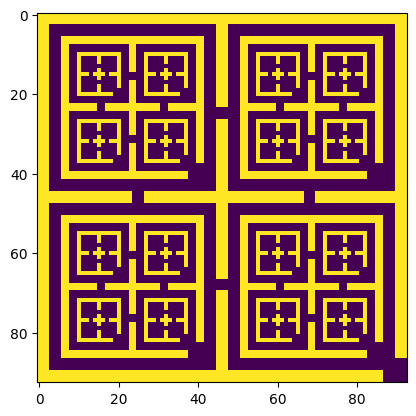

In [59]:
from utils import load_tree_model

In [67]:
np.array([1,2,3])[:,None]

array([[1],
       [2],
       [3]])

In [69]:
def generate_negative_samples(state, action, config):
    batch_size = state.shape[0]
    device = state.device

    # Create a range tensor for each item in the batch
    range_tensor = torch.arange(config.branching_factor + 2, device=device).unsqueeze(0).expand(batch_size, -1)

    # Create a mask to exclude the actual action for each item in the batch
    mask = range_tensor != action.unsqueeze(1)

    # Use the mask to select negative actions
    neg_actions = range_tensor[mask].view(batch_size, -1)

    # Repeat state for each negative action
    repeated_states = state.unsqueeze(1).expand(-1, config.branching_factor + 1, -1)

    # Combine repeated states with negative actions
    negative_full = torch.cat([repeated_states, neg_actions.unsqueeze(-1)], dim=-1)

    return negative_full

In [74]:
import torch

def generate_negative_samples(state, action, config):
    batch_size = state.shape[0]
    device = state.device

    # Create a range tensor for each item in the batch
    range_tensor = torch.arange(config.branching_factor + 2, device=device).unsqueeze(0).expand(batch_size, -1)

    # Create a mask to exclude the actual action for each item in the batch
    mask = range_tensor != action.unsqueeze(1)

    # Use the mask to select negative actions
    neg_actions = range_tensor[mask].view(batch_size, -1)

    # Repeat state for each negative action
    repeated_states = state.unsqueeze(1).expand(-1, config.branching_factor + 1)

    # Combine repeated states with negative actions
    negative_full = torch.stack([repeated_states, neg_actions], dim=-1)

    return negative_full

# Example usage:
batch_size = 3
config = type('Config', (), {'branching_factor': 3})()

# Example batched inputs (states are now integers)
state = torch.randint(0, 100, (batch_size,))  # Assuming states are integers from 0 to 99
action = torch.randint(0, config.branching_factor + 2, (batch_size,))

# Move tensors to the desired device (e.g., cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state = state.to(device)
action = action.to(device)

# Generate negative samples
negative_full = generate_negative_samples(state, action, config)

print(f"State shape: {state.shape}")
print(f"Action shape: {action.shape}")
print(f"Negative samples shape: {negative_full.shape}")
print(f"Negative samples:\n{negative_full}")

State shape: torch.Size([3])
Action shape: torch.Size([3])
Negative samples shape: torch.Size([3, 4, 2])
Negative samples:
tensor([[[11,  0],
         [11,  1],
         [11,  2],
         [11,  4]],

        [[ 3,  0],
         [ 3,  1],
         [ 3,  2],
         [ 3,  4]],

        [[ 7,  0],
         [ 7,  1],
         [ 7,  2],
         [ 7,  3]]])


In [73]:
negative_full

tensor([[[ 0.1131, -2.6850,  0.0000],
         [ 0.1131, -2.6850,  2.0000],
         [ 0.1131, -2.6850,  3.0000],
         [ 0.1131, -2.6850,  4.0000]],

        [[-0.0903,  1.7367,  0.0000],
         [-0.0903,  1.7367,  1.0000],
         [-0.0903,  1.7367,  2.0000],
         [-0.0903,  1.7367,  4.0000]],

        [[ 0.4853,  1.0013,  1.0000],
         [ 0.4853,  1.0013,  2.0000],
         [ 0.4853,  1.0013,  3.0000],
         [ 0.4853,  1.0013,  4.0000]]])